In [1]:
using Yao,Yao.Blocks,Yao.Interfaces,Yao.Registers,Yao.Intrinsics;
using PyPlot;
using LinearAlgebra;
using DataFrames;
using Random;
using JLD;
# using Plots;
using Statistics;
using CSV;

In [191]:
stryatemp=[1 0 0 0;0 (1-1.0im)/2 (1+1.0im)/2 0;0 (1+1.0im)/2 (1-1.0im)/2 0;0 0 0 1]
ϕ=0.3*pi
ϕ_1=0.2*pi
f1=0.96
f2=0.98

ownphasegate=GeneralMatrixGate([exp(-1im*(ϕ_1+pi/4)) 0 0 0;0 1 0 0;0 0 exp(-1im*pi/2) 0;0 0 0 exp(-1im*(-ϕ_1+pi/4))]);
sqrtswap=GeneralMatrixGate([exp(-1im*ϕ) 0 0 0;0 (1-1.0im)/2 (1+1.0im)/2 0;0 (1+1.0im)/2 (1-1.0im)/2 0;0 0 0 exp(1im*ϕ)]);
# sqrtswapdag=GeneralMatrixGate([exp(-1im*ϕ) 0 0 0; 0 0.5+0.5im 0.5-0.5im 0; 0.0 0.5-0.5im 0.5+0.5im 0.0; 0.0 0.0 0 exp(1im*ϕ)]);
phspinflipgate1=GeneralMatrixGate([sqrt(1-f1) sqrt(f1);sqrt(f1) sqrt(1-f1)]);
spinflipgate2=GeneralMatrixGate([sqrt(f2) sqrt(1-f2);sqrt(1-f2) sqrt(f2)]);
asegate=GeneralMatrixGate([exp(-1im*ϕ/2) 0;0 exp(1im*ϕ/2)]);

phasegate=GeneralMatrixGate([exp(-1im*ϕ/2) 0;0 exp(1im*ϕ/2)]);

In [192]:
seq=chain(10,put(10,2=>spinflipgate),put(10,4=>spinflipgate1),put(10,6=>spinflipgate1),
        put(10,8=>spinflipgate1),put(10,10=>spinflipgate1),
        put(10,1=>spinflipgate2),put(10,3=>spinflipgate2),
        put(10,5=>spinflipgate2),put(10,7=>spinflipgate2),put(10,9=>spinflipgate2),
        put(10,(1,2)=>sqrtswap),put(10,(3,4)=>sqrtswap),put(10,(5,6)=>sqrtswap),
        put(10,(7,8)=>sqrtswap),put(10,(9,10)=>sqrtswap),

        put(10,(1,2)=>ownphasegate),put(10,(3,4)=>ownphasegate),put(10,(5,6)=>ownphasegate),
        put(10,(7,8)=>ownphasegate),put(10,(9,10)=>ownphasegate),

        put(10,1=>phasegate),put(10,10=>phasegate),

        put(10,(2,3)=>sqrtswap),put(10,(4,5)=>sqrtswap),put(10,(6,7)=>sqrtswap),put(10,(8,9)=>sqrtswap))

reg1times10=product_state(10,0b0000000000)
# @show reg.state
apply!(reg1times10,seq)
s=[(i,reg1times10.state[i]) for i=1:length(reg1times10.state) if reg1times10.state[i]!=0]
s

518-element Array{Tuple{Int64,Complex{Float64}},1}:
 (172, 0.029710859178505765 + 0.029710859178505765im)    
 (174, 0.029710859178505765 - 0.029710859178505765im)    
 (175, -0.05942171835701153 - 1.3877787807814457e-17im)  
 (176, 0.0070563619537711425 + 0.00971224901747125im)    
 (180, 0.029710859178505765 - 0.029710859178505765im)    
 (182, -0.029710859178505765 - 0.029710859178505765im)   
 (183, -1.3877787807814457e-17 + 0.05942171835701153im)  
 (184, 0.00971224901747125 - 0.0070563619537711425im)    
 (186, -0.05942171835701153 + 0.05942171835701153im)     
 (187, 2.0816681711721685e-17 - 0.05942171835701154im)   
 (188, -0.0026558870637001034 + 0.016768610971242392im)  
 (189, 0.05942171835701154 + 2.0816681711721685e-17im)   
 (190, 0.0026558870637001034 - 0.016768610971242392im)   
 ⋮                                                       
 (1012, 0.0015494714061976022 + 1.1762711253452524e-5im) 
 (1013, -0.0015571874141066468 - 0.003056152377966105im) 
 (1014, -0.000617436

In [193]:
usefulposition=[]

for i in 1:(2^10-1)
    position=tuple(baddrs(i)...)
    reg=copy(reg1times10)
    tracestate=reg |> focus!(position...)|> ρ
    relax!(reg,position)
    gx=fill(X,length(position))
    gy=fill(Y,length(position))
    gz=fill(Z,length(position))
    tmp=[abs(expect(KronBlock(gx...),tracestate)),abs(expect(KronBlock(gy...),tracestate)),
        abs(expect(KronBlock(gz...),tracestate))]
    if sum(tmp)>1
        println(position,",",tmp)
        append!(usefulposition,i)
    end
end

(1, 2),[0.473908, 0.486492, 0.4798]
(1, 3),[0.492549, 0.467851, 0.4798]
(1, 2, 3, 4),[0.46443, 0.476762, 0.460608]
(1, 2, 3, 5),[0.482698, 0.458494, 0.460608]
(1, 2, 3, 4, 5, 6),[0.455141, 0.467227, 0.442184]
(1, 2, 3, 4, 5, 7),[0.473044, 0.449324, 0.442184]
(1, 2, 3, 4, 5, 6, 7, 8),[0.446038, 0.457882, 0.424496]
(1, 2, 3, 4, 5, 6, 7, 9),[0.463583, 0.440338, 0.424496]
(8, 10),[0.492549, 0.467851, 0.4798]
(9, 10),[0.473908, 0.486492, 0.4798]
(6, 8, 9, 10),[0.482698, 0.458494, 0.460608]
(7, 8, 9, 10),[0.46443, 0.476762, 0.460608]
(4, 6, 7, 8, 9, 10),[0.473044, 0.449324, 0.442184]
(5, 6, 7, 8, 9, 10),[0.455141, 0.467227, 0.442184]
(2, 4, 5, 6, 7, 8, 9, 10),[0.463583, 0.440338, 0.424496]
(3, 4, 5, 6, 7, 8, 9, 10),[0.446038, 0.457882, 0.424496]
(1, 2, 3, 4, 5, 6, 7, 8, 9, 10),[0.903921, 0.903921, 0.815373]


In [208]:
position=(1,2,3,4,5,6,7,8,9,10)    
gx=fill(X,length(position))
gy=fill(Y,length(position))
gz=fill(Z,length(position))
reslistx=zeros((40,30))
reslisty=zeros((40,30))
reslistz=zeros((40,30))

f1list=LinRange(0.92,1.0,40)
f2list=LinRange(0.92,1.0,30)

i=0
for fx in f1list
    if i%5==0
        print(i,',')
    end
    i+=1
    f1=fx
    j=0
    for fy in f2list
        j+=1
        ϕ=0
        ϕ_1=0
        # ϕ_1=0.2*pi
        f2=fy
        ownphasegate=GeneralMatrixGate([exp(-1im*(ϕ_1+pi/4)) 0 0 0;0 1 0 0;0 0 exp(-1im*pi/2) 0;0 0 0 exp(-1im*(-ϕ_1+pi/4))]);
        sqrtswap=GeneralMatrixGate([exp(-1im*ϕ) 0 0 0;0 (1-1.0im)/2 (1+1.0im)/2 0;0 (1+1.0im)/2 (1-1.0im)/2 0;0 0 0 exp(1im*ϕ)]);
        # sqrtswapdag=GeneralMatrixGate([exp(-1im*ϕ) 0 0 0; 0 0.5+0.5im 0.5-0.5im 0; 0.0 0.5-0.5im 0.5+0.5im 0.0; 0.0 0.0 0 exp(1im*ϕ)]);
        spinflipgate1=GeneralMatrixGate([sqrt(1-f1) sqrt(f1);sqrt(f1) sqrt(1-f1)]);
        spinflipgate2=GeneralMatrixGate([sqrt(f2) sqrt(1-f2);sqrt(1-f2) sqrt(f2)]);
        phasegate=GeneralMatrixGate([exp(-1im*ϕ/2) 0;0 exp(1im*ϕ/2)]);
        seq=chain(10,put(10,2=>spinflipgate),put(10,4=>spinflipgate1),put(10,6=>spinflipgate1),
        put(10,8=>spinflipgate1),put(10,10=>spinflipgate1),
        put(10,1=>spinflipgate2),put(10,3=>spinflipgate2),
        put(10,5=>spinflipgate2),put(10,7=>spinflipgate2),put(10,9=>spinflipgate2),
        put(10,(1,2)=>sqrtswap),put(10,(3,4)=>sqrtswap),put(10,(5,6)=>sqrtswap),
        put(10,(7,8)=>sqrtswap),put(10,(9,10)=>sqrtswap),

        put(10,(1,2)=>ownphasegate),put(10,(3,4)=>ownphasegate),put(10,(5,6)=>ownphasegate),
        put(10,(7,8)=>ownphasegate),put(10,(9,10)=>ownphasegate),

        put(10,1=>phasegate),put(10,10=>phasegate),

        put(10,(2,3)=>sqrtswap),put(10,(4,5)=>sqrtswap),put(10,(6,7)=>sqrtswap),put(10,(8,9)=>sqrtswap))

        reg=product_state(10,0b0000000000)
        # @show reg.state
        apply!(reg,seq)
        tracestate=reg |> focus!(position...)|> ρ
        tmp=[abs(expect(KronBlock(gx...),tracestate)),abs(expect(KronBlock(gy...),tracestate)),
            abs(expect(KronBlock(gz...),tracestate))]
#         push!(reslist,tmp)
        reslistx[i,j]=tmp[1]
        reslisty[i,j]=tmp[2]
        reslistz[i,j]=tmp[3]
    end
end
    
# PyPlot.plot(LinRange(0,pi,100),reslist)
# PyPlot.grid()
    

0,5,10,15,20,25,30,35,

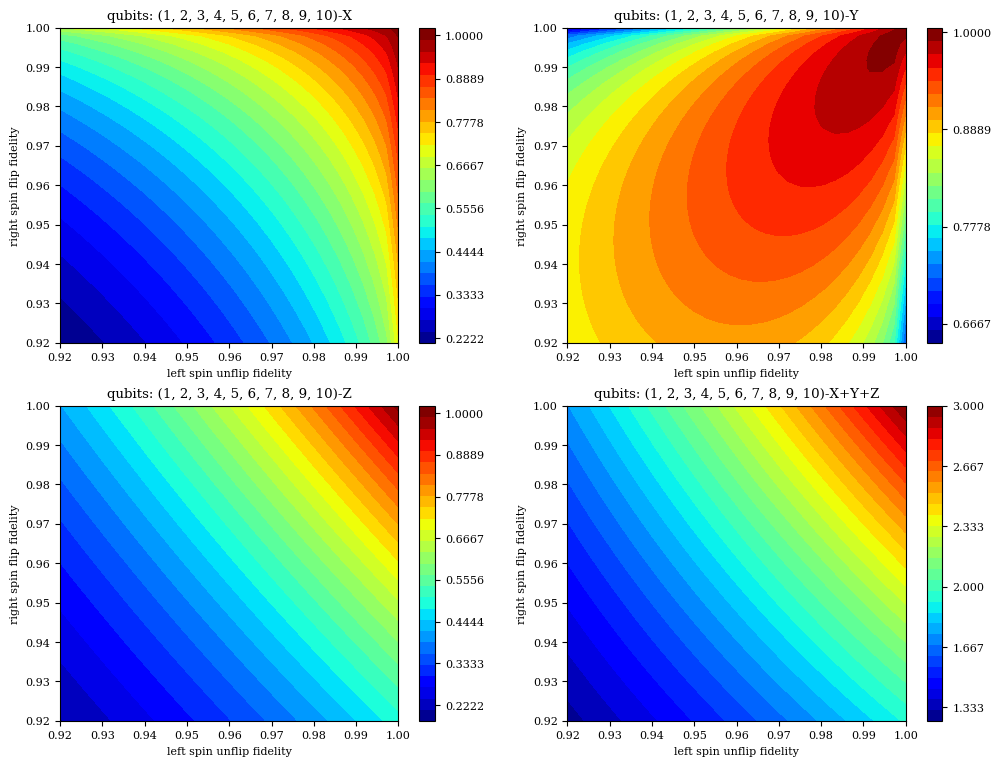

PyObject <matplotlib.colorbar.Colorbar object at 0x1586e62e8>

In [209]:
rc("font", family="serif",size=8)
PyPlot.figure(figsize=(12,9))
title(string(position))
# Plots.scalefontsizes(0)
# X,Y=ndgrid(omegalist,deltalist)

subplot(2,2,1)
title(string("qubits: ",position,"-X"))
PyPlot.contourf(f2list,f1list,reslistx,
    levels=30,cmap="jet",vmax=1)
# Plots.pdf("test.pdf")
PyPlot.xlabel("left spin unflip fidelity")
PyPlot.ylabel("right spin flip fidelity")
PyPlot.colorbar(ticks=LinRange(0,1,10))

subplot(2,2,2)
title(string("qubits: ",position,"-Y"))
# Plots.scalefontsizes(0)
# X,Y=ndgrid(omegalist,deltalist)
PyPlot.contourf(f2list,f1list,reslisty,
    levels=30,cmap="jet",vmax=1)
PyPlot.colorbar(ticks=LinRange(0,1,10))
# Plots.pdf("test.pdf")
PyPlot.xlabel("left spin unflip fidelity")
PyPlot.ylabel("right spin flip fidelity")


subplot(2,2,3)
title(string("qubits: ",position,"-Z"))
# Plots.scalefontsizes(0)
# X,Y=ndgrid(omegalist,deltalist)
PyPlot.contourf(f2list,f1list,reslistz,
    levels=30,cmap="jet",vmax=1)
# Plots.pdf("test.pdf")
PyPlot.xlabel("left spin unflip fidelity")
PyPlot.ylabel("right spin flip fidelity")
PyPlot.colorbar(ticks=LinRange(0,1,10))

subplot(2,2,4)
title(string("qubits: ",position,"-X+Y+Z"))
# Plots.scalefontsizes(0)
# X,Y=ndgrid(omegalist,deltalist)
PyPlot.contourf(f2list,f1list,reslistz.+reslistx.+reslisty,
    levels=30,cmap="jet",vmax=3)
# Plots.pdf("test.pdf")
PyPlot.xlabel("left spin unflip fidelity")
PyPlot.ylabel("right spin flip fidelity")
PyPlot.colorbar(ticks=LinRange(0,3,10))

# savefig("SpinFlipFidelity.pdf",bbox_inches="tight")

In [203]:
f1list=LinRange(0.92,1.0,40)
f2list=LinRange(0.92,1.0,40)

positionum=length(usefulposition)

reslistx=zeros((positionum,40))
reslisty=zeros((positionum,40))
reslistz=zeros((positionum,40))

f1=1
ownphasegate=GeneralMatrixGate([exp(-1im*(ϕ_1+pi/4)) 0 0 0;0 1 0 0;0 0 exp(-1im*pi/2) 0;0 0 0 exp(-1im*(-ϕ_1+pi/4))]);
sqrtswap=GeneralMatrixGate([exp(-1im*ϕ) 0 0 0;0 (1-1.0im)/2 (1+1.0im)/2 0;0 (1+1.0im)/2 (1-1.0im)/2 0;0 0 0 exp(1im*ϕ)]);
spinflipgate1=GeneralMatrixGate([sqrt(1-f1) sqrt(f1);sqrt(f1) sqrt(1-f1)]);

i=0
for positioni in usefulposition
    position=tuple(baddrs(positioni)...)
    i+=1
    j=0
    for fy in f2list
        j+=1
        ϕ=0
        ϕ_1=0
        # ϕ_1=0.2*pi
        f2=fy
#         ownphasegate=GeneralMatrixGate([exp(-1im*(ϕ_1+pi/4)) 0 0 0;0 1 0 0;0 0 exp(-1im*pi/2) 0;0 0 0 exp(-1im*(-ϕ_1+pi/4))]);
#         sqrtswap=GeneralMatrixGate([exp(-1im*ϕ) 0 0 0;0 (1-1.0im)/2 (1+1.0im)/2 0;0 (1+1.0im)/2 (1-1.0im)/2 0;0 0 0 exp(1im*ϕ)]);
        # sqrtswapdag=GeneralMatrixGate([exp(-1im*ϕ) 0 0 0; 0 0.5+0.5im 0.5-0.5im 0; 0.0 0.5-0.5im 0.5+0.5im 0.0; 0.0 0.0 0 exp(1im*ϕ)]);
#         spinflipgate1=GeneralMatrixGate([sqrt(1-f1) sqrt(f1);sqrt(f1) sqrt(1-f1)]);
        spinflipgate2=GeneralMatrixGate([sqrt(f2) sqrt(1-f2);sqrt(1-f2) sqrt(f2)]);
        phasegate=GeneralMatrixGate([exp(-1im*ϕ/2) 0;0 exp(1im*ϕ/2)]);
        seq=chain(10,put(10,2=>spinflipgate),put(10,4=>spinflipgate1),put(10,6=>spinflipgate1),
        put(10,8=>spinflipgate1),put(10,10=>spinflipgate1),
        put(10,1=>spinflipgate2),put(10,3=>spinflipgate2),
        put(10,5=>spinflipgate2),put(10,7=>spinflipgate2),put(10,9=>spinflipgate2),
        put(10,(1,2)=>sqrtswap),put(10,(3,4)=>sqrtswap),put(10,(5,6)=>sqrtswap),
        put(10,(7,8)=>sqrtswap),put(10,(9,10)=>sqrtswap),

        put(10,(1,2)=>ownphasegate),put(10,(3,4)=>ownphasegate),put(10,(5,6)=>ownphasegate),
        put(10,(7,8)=>ownphasegate),put(10,(9,10)=>ownphasegate),

        put(10,1=>phasegate),put(10,10=>phasegate),

        put(10,(2,3)=>sqrtswap),put(10,(4,5)=>sqrtswap),put(10,(6,7)=>sqrtswap),put(10,(8,9)=>sqrtswap))

        reg=product_state(10,0b0000000000)
        # @show reg.state
        apply!(reg,seq)
        tracestate=reg |> focus!(position...)|> ρ
        
        gx=fill(X,length(position))
        gy=fill(Y,length(position))
        gz=fill(Z,length(position))
        tmp=[abs(expect(KronBlock(gx...),tracestate)),abs(expect(KronBlock(gy...),tracestate)),
            abs(expect(KronBlock(gz...),tracestate))]
#         push!(reslist,tmp)
        reslistx[i,j]=tmp[1]
        reslisty[i,j]=tmp[2]
        reslistz[i,j]=tmp[3]
    end
end

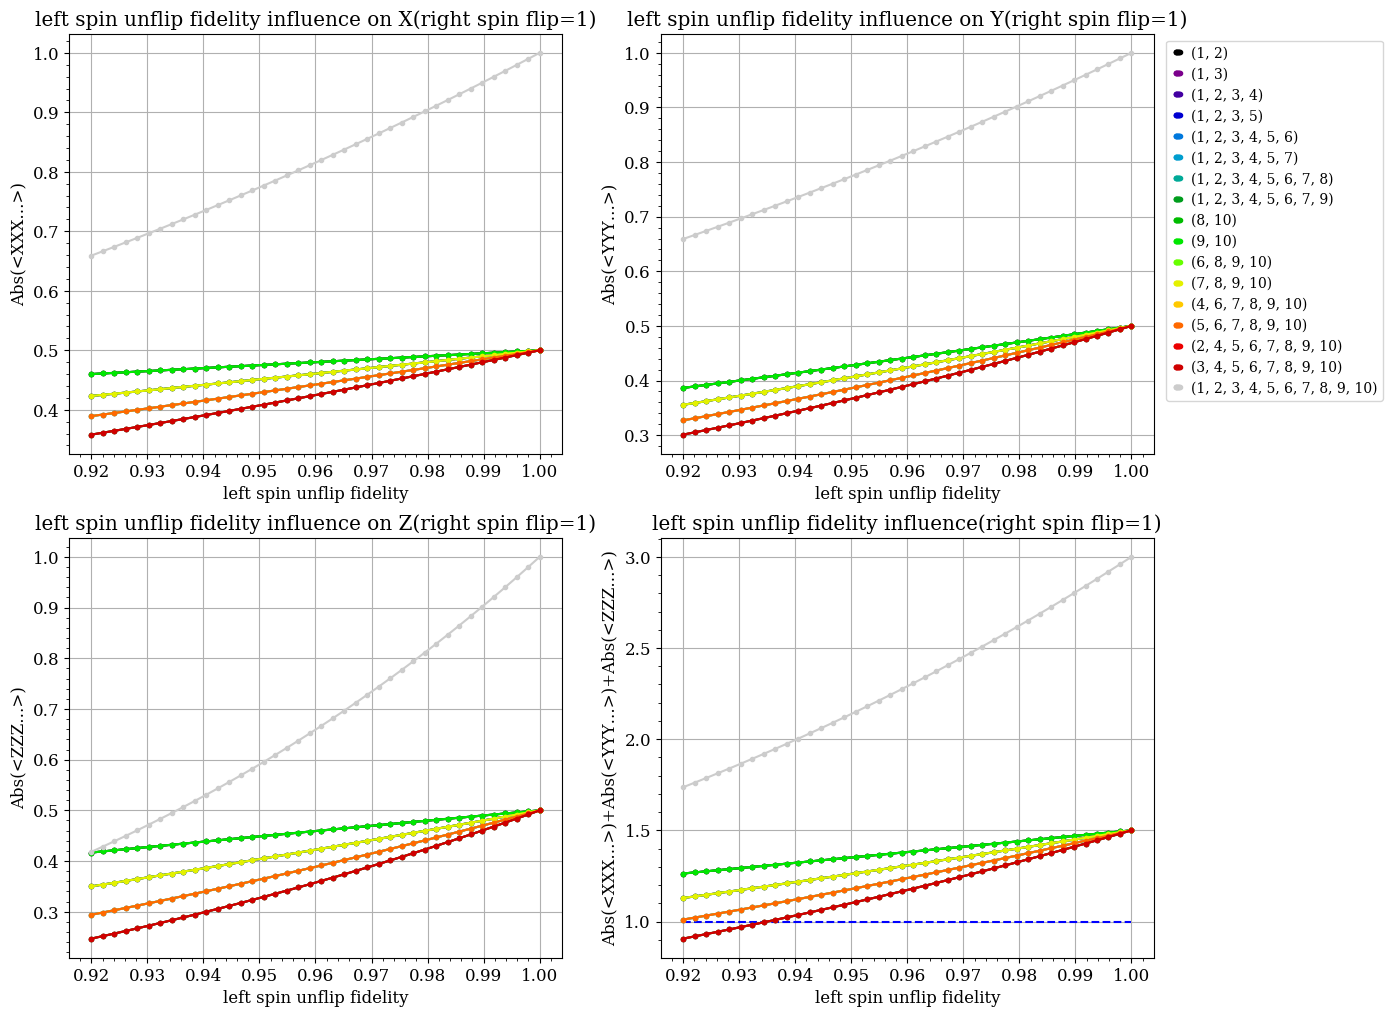

PyObject Text(618.8181818181818, 0.5, 'Abs(<XXX...>)+Abs(<YYY...>)+Abs(<ZZZ...>)')

In [204]:
rc("font", family="serif",size=12)
figure(figsize=(14,12))

colorlist=Vector(LinRange(0,1,positionum))

subplot(2,2,1)
grid()
minorticks_on()
title("left spin unflip fidelity influence on X(right spin flip=1)")
for i in 1:positionum
    plot(f2list,reslistx[i,:],".-",label=string(tuple(baddrs(usefulposition[i])...)),color=plt.cm.nipy_spectral(colorlist[i]))
end
# legend(loc="best")
xlabel("left spin unflip fidelity")
ylabel("Abs(<XXX...>)")
# legend(loc="best",fontsize=10,
#             bbox_to_anchor=(1.01,1), numpoints=10,handlelength=0.9, handletextpad=0.5)

subplot(2,2,2)
grid()
minorticks_on()
title("left spin unflip fidelity influence on Y(right spin flip=1)")
for i in 1:positionum
    plot(f2list,reslisty[i,:],".-",label=string(tuple(baddrs(usefulposition[i])...)),color=plt.cm.nipy_spectral(colorlist[i]))
end
# legend(loc="best")
xlabel("left spin unflip fidelity")
ylabel("Abs(<YYY...>)")
legend(loc="best",fontsize=10,
            bbox_to_anchor=(1.01,1), numpoints=10,handlelength=0.9, handletextpad=0.5)

subplot(2,2,3)
grid()
minorticks_on()
title("left spin unflip fidelity influence on Z(right spin flip=1)")
for i in 1:positionum
    plot(f2list,reslistz[i,:],".-",label=string(tuple(baddrs(usefulposition[i])...)),color=plt.cm.nipy_spectral(colorlist[i]))
end
# legend(loc="best")
xlabel("left spin unflip fidelity")
ylabel("Abs(<ZZZ...>)")
# legend(loc="best",fontsize=10,
#             bbox_to_anchor=(1.01,1), numpoints=10,handlelength=0.9, handletextpad=0.5)

subplot(2,2,4)
grid()
minorticks_on()
hlines(1,0.92,1.00,colors="blue", linestyles="dashed")
title("left spin unflip fidelity influence(right spin flip=1)")
for i in 1:positionum
    plot(f2list,reslistx[i,:].+reslisty[i,:].+reslistz[i,:],".-",label=string(tuple(baddrs(usefulposition[i])...)),color=plt.cm.nipy_spectral(colorlist[i]))
end
# legend(loc="best")
xlabel("left spin unflip fidelity")
ylabel("Abs(<XXX...>)+Abs(<YYY...>)+Abs(<ZZZ...>)")
# legend(loc="best",fontsize=10,
#             bbox_to_anchor=(1.01,1), numpoints=10,handlelength=0.9, handletextpad=0.5)

# savefig("LeftSpinUnflipFidelity.pdf",bbox_inches="tight")

In [205]:
f1list=LinRange(0.92,1.0,40)
f2list=LinRange(0.92,1.0,40)

positionum=length(usefulposition)

reslistx=zeros((positionum,40))
reslisty=zeros((positionum,40))
reslistz=zeros((positionum,40))

f2=1
ownphasegate=GeneralMatrixGate([exp(-1im*(ϕ_1+pi/4)) 0 0 0;0 1 0 0;0 0 exp(-1im*pi/2) 0;0 0 0 exp(-1im*(-ϕ_1+pi/4))]);
sqrtswap=GeneralMatrixGate([exp(-1im*ϕ) 0 0 0;0 (1-1.0im)/2 (1+1.0im)/2 0;0 (1+1.0im)/2 (1-1.0im)/2 0;0 0 0 exp(1im*ϕ)]);
# spinflipgate1=GeneralMatrixGate([sqrt(1-f1) sqrt(f1);sqrt(f1) sqrt(1-f1)]);
spinflipgate2=GeneralMatrixGate([sqrt(f2) sqrt(1-f2);sqrt(1-f2) sqrt(f2)]);
   
i=0
for positioni in usefulposition
    position=tuple(baddrs(positioni)...)
    i+=1
    j=0
    for fx in f1list
        j+=1
        ϕ=0
        ϕ_1=0
        # ϕ_1=0.2*pi
        f1=fx
#         ownphasegate=GeneralMatrixGate([exp(-1im*(ϕ_1+pi/4)) 0 0 0;0 1 0 0;0 0 exp(-1im*pi/2) 0;0 0 0 exp(-1im*(-ϕ_1+pi/4))]);
#         sqrtswap=GeneralMatrixGate([exp(-1im*ϕ) 0 0 0;0 (1-1.0im)/2 (1+1.0im)/2 0;0 (1+1.0im)/2 (1-1.0im)/2 0;0 0 0 exp(1im*ϕ)]);
        # sqrtswapdag=GeneralMatrixGate([exp(-1im*ϕ) 0 0 0; 0 0.5+0.5im 0.5-0.5im 0; 0.0 0.5-0.5im 0.5+0.5im 0.0; 0.0 0.0 0 exp(1im*ϕ)]);
        spinflipgate1=GeneralMatrixGate([sqrt(1-f1) sqrt(f1);sqrt(f1) sqrt(1-f1)]);
#         spinflipgate2=GeneralMatrixGate([sqrt(f2) sqrt(1-f2);sqrt(1-f2) sqrt(f2)]);
        phasegate=GeneralMatrixGate([exp(-1im*ϕ/2) 0;0 exp(1im*ϕ/2)]);
        seq=chain(10,put(10,2=>spinflipgate),put(10,4=>spinflipgate1),put(10,6=>spinflipgate1),
        put(10,8=>spinflipgate1),put(10,10=>spinflipgate1),
        put(10,1=>spinflipgate2),put(10,3=>spinflipgate2),
        put(10,5=>spinflipgate2),put(10,7=>spinflipgate2),put(10,9=>spinflipgate2),
        put(10,(1,2)=>sqrtswap),put(10,(3,4)=>sqrtswap),put(10,(5,6)=>sqrtswap),
        put(10,(7,8)=>sqrtswap),put(10,(9,10)=>sqrtswap),

        put(10,(1,2)=>ownphasegate),put(10,(3,4)=>ownphasegate),put(10,(5,6)=>ownphasegate),
        put(10,(7,8)=>ownphasegate),put(10,(9,10)=>ownphasegate),

        put(10,1=>phasegate),put(10,10=>phasegate),

        put(10,(2,3)=>sqrtswap),put(10,(4,5)=>sqrtswap),put(10,(6,7)=>sqrtswap),put(10,(8,9)=>sqrtswap))

        reg=product_state(10,0b0000000000)
        # @show reg.state
        apply!(reg,seq)
        tracestate=reg |> focus!(position...)|> ρ
        
        gx=fill(X,length(position))
        gy=fill(Y,length(position))
        gz=fill(Z,length(position))
        tmp=[abs(expect(KronBlock(gx...),tracestate)),abs(expect(KronBlock(gy...),tracestate)),
            abs(expect(KronBlock(gz...),tracestate))]
#         push!(reslist,tmp)
        reslistx[i,j]=tmp[1]
        reslisty[i,j]=tmp[2]
        reslistz[i,j]=tmp[3]
    end
end

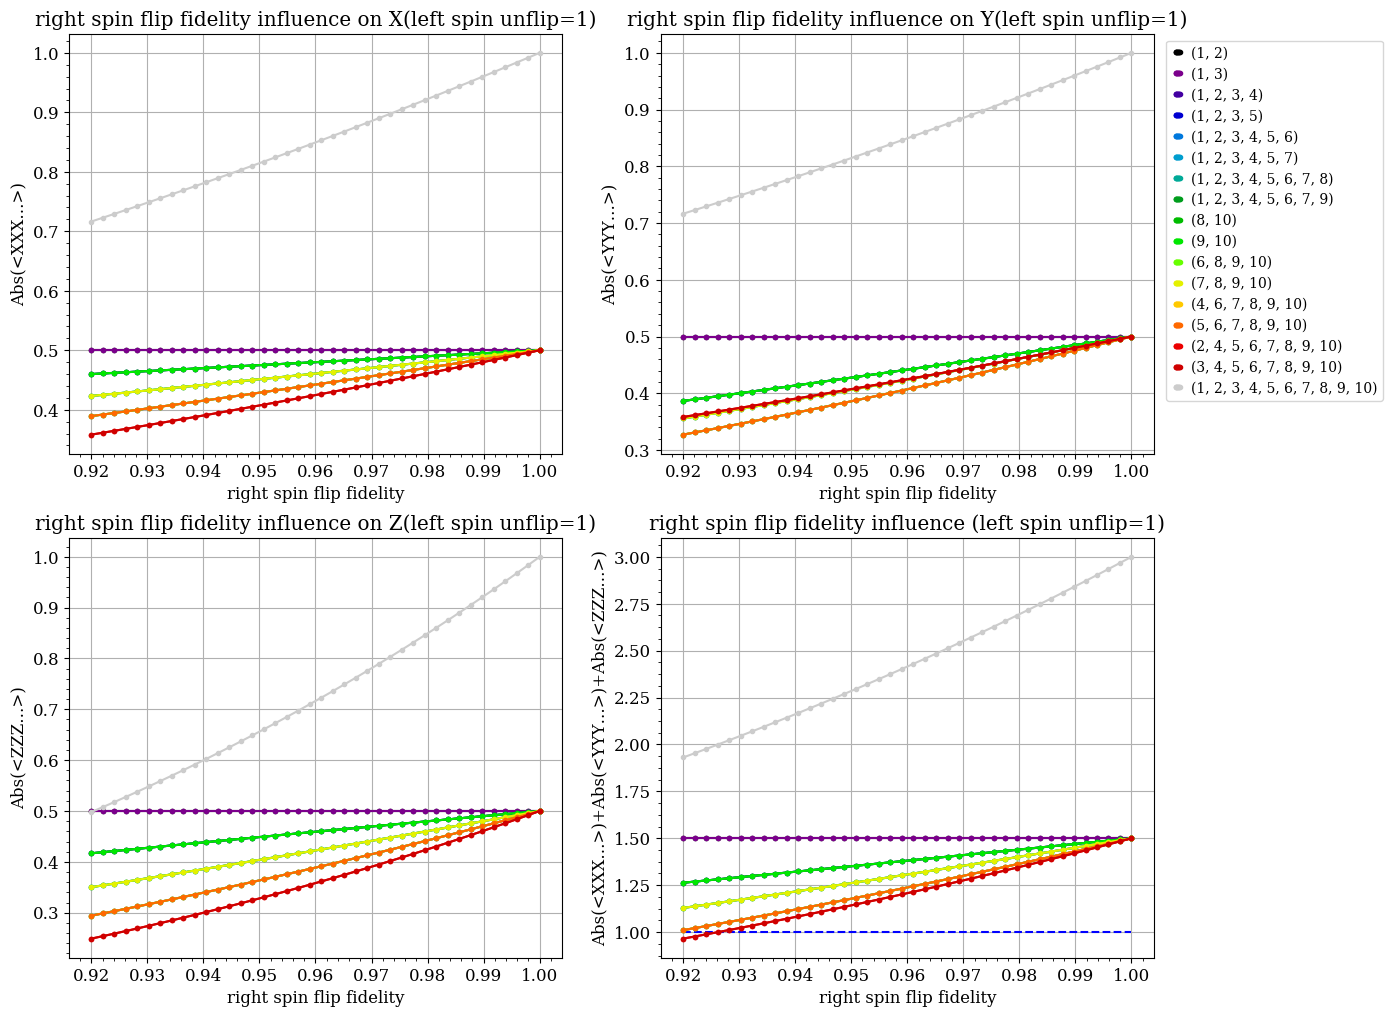

PyObject Text(608.1931818181818, 0.5, 'Abs(<XXX...>)+Abs(<YYY...>)+Abs(<ZZZ...>)')

In [206]:
rc("font", family="serif",size=12)
figure(figsize=(14,12))
colorlist=Vector(LinRange(0,1,positionum))

subplot(2,2,1)
minorticks_on()
grid()
title("right spin flip fidelity influence on X(left spin unflip=1)")
for i in 1:positionum
    plot(f2list,reslistx[i,:],".-",label=string(tuple(baddrs(usefulposition[i])...)),color=plt.cm.nipy_spectral(colorlist[i]))
end
# legend(loc="best")
xlabel("right spin flip fidelity")
ylabel("Abs(<XXX...>)")
# legend(loc="best",fontsize=10,
#             bbox_to_anchor=(1.01,1), numpoints=10,handlelength=0.9, handletextpad=0.5)

subplot(2,2,2)
grid()
minorticks_on()
title("right spin flip fidelity influence on Y(left spin unflip=1)")

for i in 1:positionum
    plot(f2list,reslisty[i,:],".-",
        label=string(tuple(baddrs(usefulposition[i])...)),color=plt.cm.nipy_spectral(colorlist[i]))
end
# legend(loc="best")
xlabel("right spin flip fidelity")
ylabel("Abs(<YYY...>)")
legend(loc="best",fontsize=10,
            bbox_to_anchor=(1.01,1), numpoints=10,handlelength=0.9, handletextpad=0.5)

subplot(2,2,3)
grid()
minorticks_on()
title("right spin flip fidelity influence on Z(left spin unflip=1)")
for i in 1:positionum
    plot(f2list,reslistz[i,:],".-",label=string(tuple(baddrs(usefulposition[i])...)),color=plt.cm.nipy_spectral(colorlist[i]))
end
# legend(loc="best")
xlabel("right spin flip fidelity")
ylabel("Abs(<ZZZ...>)")
# legend(loc="best",fontsize=10,
#             bbox_to_anchor=(1.01,1), numpoints=10,handlelength=0.9, handletextpad=0.5)

subplot(2,2,4)
grid()
minorticks_on()
hlines(1,0.92,1.00,colors="blue", linestyles="dashed")
title("right spin flip fidelity influence (left spin unflip=1)")
for i in 1:positionum
    plot(f2list,reslistx[i,:].+reslisty[i,:].+reslistz[i,:],".-",label=string(tuple(baddrs(usefulposition[i])...)),color=plt.cm.nipy_spectral(colorlist[i]))
end
# legend(loc="best")
xlabel("right spin flip fidelity")
ylabel("Abs(<XXX...>)+Abs(<YYY...>)+Abs(<ZZZ...>)")
# legend(loc="best",fontsize=10,
#             bbox_to_anchor=(1.01,1), numpoints=10,handlelength=0.9, handletextpad=0.5)

# savefig("RightSpinFlipFidelity.pdf",bbox_inches="tight")